<a href="https://colab.research.google.com/github/MinabutdinovAlmaz/MlPython/blob/main/MinabutdinovAA_4405_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VAE с генерацией новых лиц

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import requests

In [ ]:
# Загрузка zip-архива датасета
save_path= '/content/celeba.zip'
!gdown --fuzzy -O /content/celeba.zip 'https://drive.google.com/file/d/1mhrPEXg9cNNfJO2JR4KIG66pjGuyAJzA/view?usp=sharing'
# Распаковка
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall("celeba")

Downloading...
From (original): https://drive.google.com/uc?id=1mhrPEXg9cNNfJO2JR4KIG66pjGuyAJzA
From (redirected): https://drive.google.com/uc?id=1mhrPEXg9cNNfJO2JR4KIG66pjGuyAJzA&confirm=t&uuid=42c66c64-f041-487f-93a5-49bbaa8b3245
To: /content/celeba.zip
100% 1.44G/1.44G [00:20<00:00, 70.5MB/s]


In [ ]:
# Создание энкодера
def build_encoder(img_shape, latent_dim):
    inputs = layers.Input(shape=img_shape)
    x = layers.Conv2D(32, (3, 3), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Flatten()(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    return models.Model(inputs, [z_mean, z_log_var], name="encoder")

In [ ]:
# Создание декодера
def build_decoder(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 128)(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    return models.Model(inputs, outputs, name="decoder")

In [ ]:
# Создание VAE
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling(z_mean, z_log_var)
        return self.decoder(z)

    def sampling(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def vae_loss(self, inputs, outputs):
        z_mean, z_log_var = self.encoder(inputs)
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(inputs, outputs))
        reconstruction_loss *= img_shape[0] * img_shape[1]  # Масштабирование для изображений
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        return reconstruction_loss + kl_loss

In [ ]:
#подготовка датасета CelebA
def load_and_preprocess_celeba(dataset_path, img_rows, img_cols):
    img_chns = 3
    image_paths = [os.path.join(dataset_path, filename) for filename in os.listdir(dataset_path)]
    num_images = len(image_paths)

    # Выделим память под весь датасет
    images = np.zeros((num_images, img_rows, img_cols, img_chns), dtype=np.float32)
    num_fact = 0

    for i, path in enumerate(image_paths):
        try:  # Обработка возможных проблем при чтении файла
            img = tf.keras.preprocessing.image.load_img(path, target_size=(img_rows, img_cols))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # Нормализация
            images[i] = img_array

            #для отображения статуса загрузки
            if i % 10000 == 0:
              print('Загружено картинок', i)

            #условие остановки цикла на 50 тыс примерах
            if i == 50000:
              num_fact = i
              break
        except Exception as e:
            print(f"Ошибка при обработке изображения {path}: {e}")
            images[i] = np.zeros((img_rows, img_cols, img_chns))  # Заполняем нулями, чтобы не было ошибок

    # Разделение на обучающую и тестовую выборки
    train_size = int(0.8 * num_fact)
    x_train = images[:train_size]
    x_test = images[train_size:num_fact]
    print(f"Загружено {num_fact} изображений из {dataset_path}.")
    print(f"Размер обучающей выборки: {x_train.shape}")
    print(f"Размер тестовой выборки: {x_test.shape}")
    return x_train, x_test

In [ ]:
# Параметры
batch_size = 32
latent_dim = 128  # Размерность latent-пространства
img_shape = (64, 64, 3)  # Размер изображений (64x64, RGB)
epochs = 60

In [ ]:
DATASET_PATH= '/content/celeba/img_align_celeba'
x_train, x_test = load_and_preprocess_celeba(DATASET_PATH, img_shape[0], img_shape[1])

Загружено картинок 0
Загружено картинок 10000
Загружено картинок 20000
Загружено картинок 30000
Загружено картинок 40000
Загружено картинок 50000
Загружено 50000 изображений из /content/celeba/img_align_celeba.
Размер обучающей выборки: (40000, 64, 64, 3)
Размер тестовой выборки: (10000, 64, 64, 3)


In [ ]:
# Создание моделей
encoder = build_encoder(img_shape, latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)
# Компиляция VAE
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=vae.vae_loss)

# Обучение VAE
def train_vae(vae, train_dataset, epochs=40):
    for epoch in range(epochs):
        for batch in train_dataset:
            vae.train_on_batch(batch, batch)

        print(f"Epoch {epoch + 1}/{epochs}")
        # Вывод прогресса
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}")
            generate_images(vae, latent_dim)

# Генерация изображений
def generate_images(vae, latent_dim, num_images=16):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_images = vae.decoder.predict(noise)

    plt.figure(figsize=(4, 4))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

In [ ]:
# Создание tf.data.Dataset для эффективной подачи данных
buffer_size = x_train.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 10/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


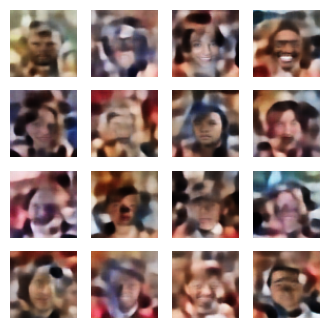

Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 20/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


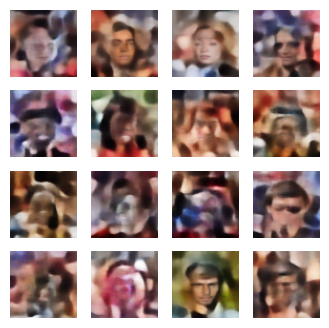

Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 30/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


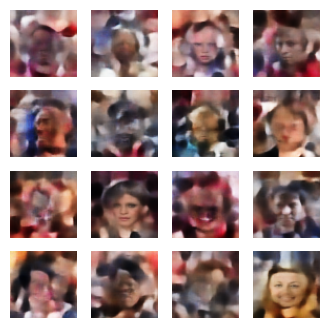

Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 40/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


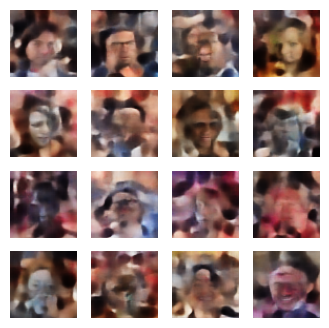

Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 50/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


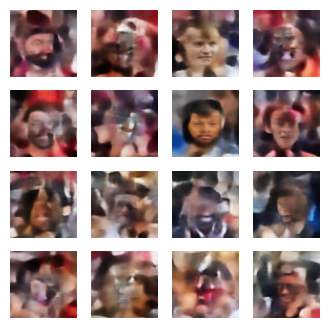

Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60
Epoch 60/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


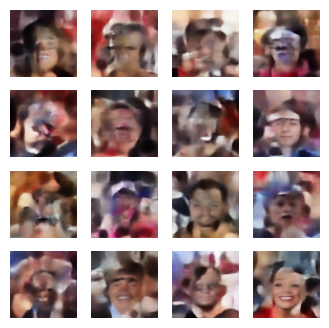

In [ ]:
# Запуск обучения
train_vae(vae, train_dataset, epochs=epochs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(64, 64, 3)


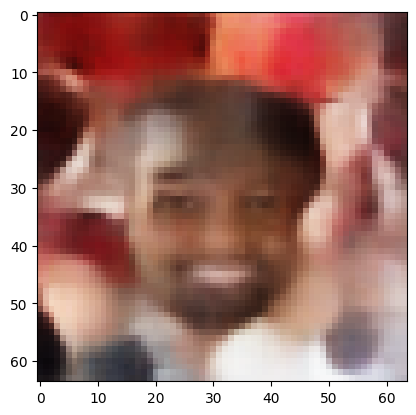

In [ ]:
noise_g = tf.random.normal(shape=(1,latent_dim))
predict_dec = decoder.predict(noise_g).squeeze()
print(predict_dec.shape)
plt.imshow(predict_dec)
plt.show()